# League of Legends Match Analytics
## Introduction

League of Legends is a competitive video game owned by Riot Games in which 10 players compete against each other in teams of 5. It is one of the most played and viewed video games in the world. Since 2011, Riot Games has hosted professional "leagues" in various regions around the world. The best teams from each region come to the Wold Championship where the best team wins the Summoner's Cup. Since its inception, the World Championship has been dominated by the Korean teams. This is an attempt to apply data driven methods to find latent variables that can explain the Korean dominance in professional League of Legends matches. All of the data has been kindly provided by [Tim Sevenhuysen](https://twitter.com/TimSevenhuysen) on his website: [Oracle's Elixir](https://oracleselixir.com/).

## Exploratory analysis

To make the analysis easier, I'm doing to import a bunch of packages and define some methods first

In [345]:
import sys
sys.path.append(".//utils//")
import sqlite3, os
import pandas as pd
import parsing_utils
from parsing_utils import parse_databases
importlib.reload(parsing_utils)
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from IPython.display import display_html

def display_side_by_side(*args):
    html_str=''
    for df in args:
        if isinstance(df,pd.Series):
            df = df.to_frame()
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

def get_matches(db_dir, year, focus, season, aliases, leagues, joins, anti_joins):
    all_matches = {}
    all_teams = {}
    parser = parse_databases()
    for ii, jj in zip(aliases,leagues):
        alias = ii
        league = jj
        name = "{}_{}_{}_{}s".format(year,alias,season,focus)
        matches,teams  = parser.parse_tables_get_matches(db_dir,alias,joins,anti_joins,name,year,league)
        try:
            name = matches["league"].value_counts().index.values[0]
            all_matches[name] = matches
            all_teams[name] = teams
            print(matches["league"].value_counts())
        except:
            print("League {} does not have any data for {}".format(jj,season))
    return all_matches, all_teams

def get_fig_axes(n=1,m=2,w=10,h=5,sharey=False):
    fig,ax = plt.subplots(n,m,figsize=(w,h),sharey=sharey)
    axes = ax.flatten()
    return fig,axes
parser = parse_databases()
db_dir =  ".//databases"
match,random = parser.get_dbs(db_dir)

In [346]:
year = "2017"
focus = "player"
season = "world"
joins = [year,focus,season]
anti_joins = ["na-cs","eu-cs"]
#aliases = ["na","lck"]
#leagues = ["NALCS","LCK"]
aliases = ["international"]
leagues = [""]
all_player_stats, all_teams = get_matches(db_dir, year, focus, season, aliases, leagues, joins, anti_joins)

NALCS     1525
LCK       1465
LPL       1465
EULCS     1275
WC        1190
LMS        935
MSI        500
TCL        355
RRNAEU     135
RRAsia     130
Name: league, dtype: int64


Now, if we look at the top 5 teams from the World Championships since 2014, we can see that Korean and Chinese teams usually dominate the field:

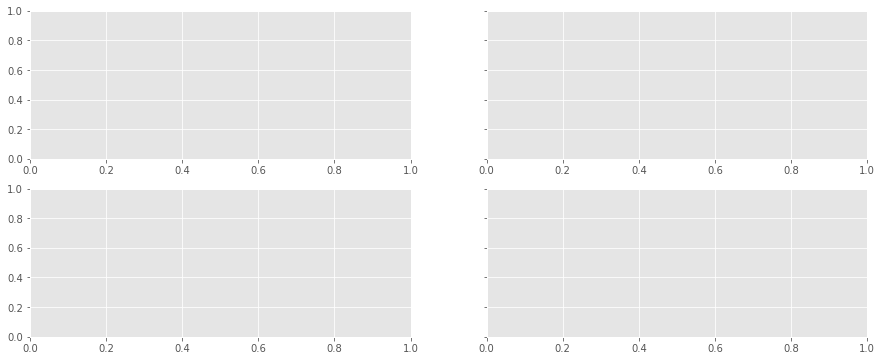

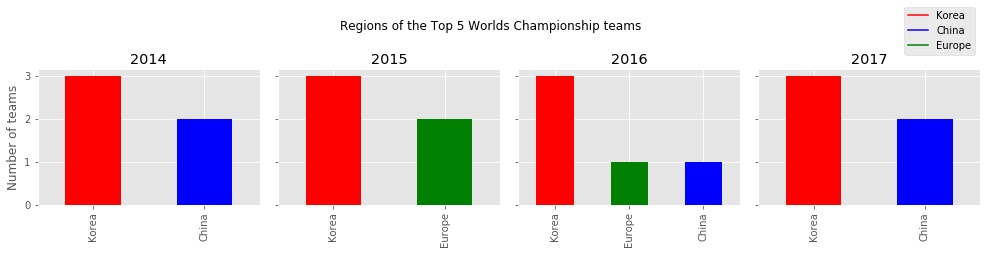

In [347]:
parser = parse_databases()
db_dir =  ".//databases"
match,random = parser.get_dbs(db_dir)
regions = {'2014':['Korea','Korea','Korea','China','China'],'2015':['Korea','Korea','Europe','Europe','Korea'],
          '2016':['Korea','Korea','Korea','Europe','China'],'2017':['Korea','Korea','China','China','Korea']}
fig,ax = plt.subplots(1,4,figsize=(14,3), sharey=True)
axes = ax.flatten()
colors = {'Korea':'r','China':'b','Europe':'g'}
n=0
axes[0].set_ylabel("Number of teams")
for ii in ['2014','2015','2016','2017']:
    query="""SELECT name FROM international.'sqlite_master' WHERE type = 'table' 
    AND name LIKE '%championships%' AND name LIKE '%team%' AND name LIKE '%{}%';""".format(ii)
    table = pd.read_sql_query(query,match).iloc[0,0]
    query="""SELECT * FROM international.'{}' ORDER BY W DESC, L ASC;""".format(table)
    top5 = pd.read_sql_query(query,match).head(5)
    top5["Region"] = regions[ii]
    cols = [colors[ii] for ii in top5["Region"].value_counts().index.values]
    top5["Region"].value_counts().plot.bar(ax = axes[n], color = [cols])
    axes[n].set_title("{}".format(ii))
    n+=1
plt.suptitle("Regions of the Top 5 Worlds Championship teams",y=1.1)
legend = [plt.Line2D([0],[0],color='r',label='Korea'),plt.Line2D([0],[0],color='b',label='China')
          ,plt.Line2D([0],[0],color='g',label='Europe')]
plt.legend(handles=legend, loc='upper right',bbox_to_anchor=(1, 1.5))
plt.tight_layout()
plt.show()

European teams have made it into the top 5 in 2015 and 2016 but Korean teams have been 3 out of the top 5 teams consistently. Since 2013, Korean teams have also won the World Championship. There has been much speculation about the Korean dominance in the professional League of Legends circuit. In particular, many people have wondered why North America never seems to make it into the top 5 despite having the largest recruiting pool and the most enthusiastic fan base. I will try to answer the question by analyzing matches from the LCK (Korean circuit) and NA (North American circuit). Specifically, I will be comparing LCK with NA matches. I unfortunately only have complete match data for the 2016 and 2017 seasons so I will be limited to the last couple of years. I will start with 2017 first since it is more recent and is not too different in terms of gameplay changes to 2018. Lets see what we can find! 
### Choosing teams
In order to make a fair comparison between the two regions, I have to pick teams that I believe best represent these regions. I decided to use teams that made it to the Spring or Summer season playoffs in the respective years. If a team made it to either of the playoffs that year, that means they must have been better than at least half the teams in their region in that season since only half the teams that compete in a region move to the playoffs. Thus, I will be comparing the top 50% of Korean teams with the top 50% of North American teams in that same year. First let's get the 2017 matches for playoff teams in LCK and NA. I have custom scripts that parse my databases and give me the matches I want. The specific implementation can be found in `parsing_utils.py`. 
### Match team statistics

First, lets look at the overall team stats for each match. This will give us team wide stats for each match rather than each player's stats:

In [351]:
year = "2017"
focus = "team"
season = "playoffs"
joins = [year,focus,season]
anti_joins = ["na-cs","eu-cs"]
aliases = ["na","lck"]
leagues = ["NALCS","LCK"]
all_matches,all_teams = get_matches(db_dir, year, focus, season, aliases, leagues, joins, anti_joins)
na = all_matches["NALCS"]
lck = all_matches["LCK"]

NALCS    782
Name: league, dtype: int64
LCK    606
Name: league, dtype: int64


The teams that made it to any of the NA playoffs in 2017 played a total of 782 matches together whereas the LCK teams played 606 matches. The reason for this discrepancy becomes clear when we look at the number of teams:

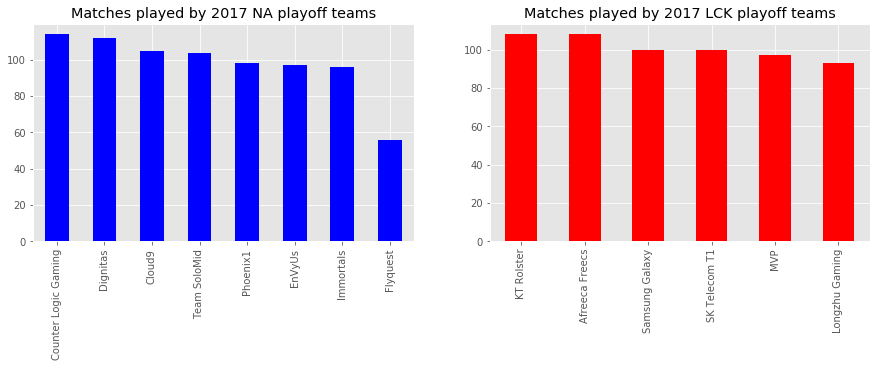

In [352]:
fig,axes = get_fig_axes(1,2,15,4)
na["team"].value_counts().plot.bar(ax=axes[0],color='b')
axes[0].set_title("Matches played by 2017 NA playoff teams")
lck["team"].value_counts().plot.bar(ax=axes[1],color='r')
axes[1].set_title("Matches played by 2017 LCK playoff teams")
plt.show()

There were only 6 teams from the LCK that made it to either the Spring or Summer playoffs compared with the 8 teams from NA. This seems to suggest that the matches in NA are more competitive than the matches in LCK. We can examine this more closely by looking at the ["GSPD"](https://oracleselixir.com/tag/gspd/) (Gold Spent Percentage Difference) statistic. "GSPD" measures if a match was a close one or if one team dominated. It measures the difference how much gold the winning team spent verses the losing team. If the difference is large, then it means the winning team had a large lead. If it is small or negative, then the losing team was keeping up in gold with the winning team. Lets compare the "GSPD" for NA vs LCK:

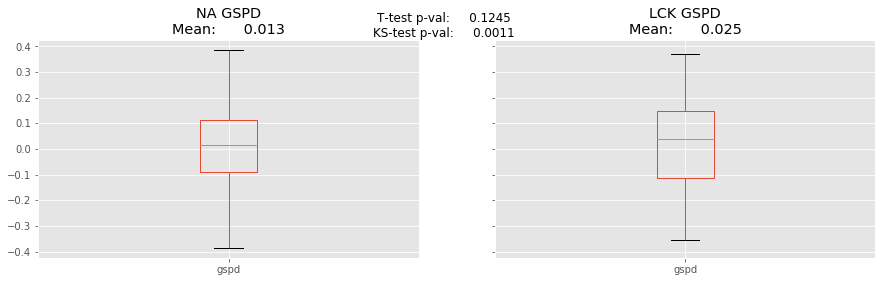

In [353]:
from scipy.stats import ttest_ind
from scipy.stats import ks_2samp
T_stat,p_val = ttest_ind(na["gspd"].values,lck["gspd"].values)
K_stat,p_val_k = ks_2samp(na["gspd"].values,lck["gspd"].values)
fig,axes = get_fig_axes(1,2,15,4,sharey=True)
na.boxplot('gspd',ax=axes[0])
axes[0].set_title("NA GSPD\nMean: {:10.3f}".format(na["gspd"].mean()))
lck.boxplot('gspd',ax=axes[1])
axes[1].set_title("LCK GSPD\nMean: {:10.3f}".format(lck["gspd"].mean()))
plt.suptitle("T-test p-val: {:10.4f}\nKS-test p-val: {:10.4f}".format(p_val,p_val_k))
plt.show()

Looking at the means and distributions, LCK in general had a higher GSPD than NA. I performed a KS test to measure if the two distributions were significantly different and a T-test for equality of the means. Although the T-test p-value is too high to say the two means are different, we can confidently say that the two distributions are different. We can be a littme more discriminant in our analysis. Lets rank the teams in the respective regions by their win rate and check their average gspd for the whole year:

In [354]:
s1 = na.groupby("team").mean().sort_values("result",ascending=False)["gspd"]
s1 = s1.rename_axis("NA Teams",axis=0).rename("2017 avg GSPD")
s2 = lck.groupby("team").mean().sort_values("result",ascending=False)["gspd"]
s2 = s2.rename_axis("LCK Teams",axis=0).rename("2017 avg GSPD")
display_side_by_side(s1,s2)

,2017 avg GSPD
NA Teams,
Team SoloMid,0.043496
Cloud9,0.029514
Immortals,0.043137
Counter Logic Gaming,-0.011401
Dignitas,-0.008613
Flyquest,-0.013037
Phoenix1,-0.007144
EnVyUs,0.019668
,2017 avg GSPD


This gives a clearer picture about what's going on. The top 3 NA teams tend to have a higher GSPD than the rest of the NA teams that qualified for playoffs whereas the LCK playoff teams tend to have a high GSPD in general. Again, this supports the notion that NA is more competitive than the LCK; the LCK teams that make it to the playoffs tend to dominate the field (according to the GSPD) whereas the NA teams tend to be more of a mixed bag. That seems interesting. Lets see if we can find a better explanation for why this is. To evaluate which features contribute to the differences between NA and LCK, I will train several models (Logistic Regression, Adaboost with Decision Trees, and Random Forest) and perform an anova to distinguish between matches in NA and LCK. Then I will see which features are the most important in distinguishing between the two groups.  

I will first clean the data for missing values by substituting the mean for some numerical columns, specific values for others, and the mode for categorical variables (this happens in the method `format_table()` in `analytics_utils.py`). I will then one hot encode categorical variables and standard scale the entire dataset.  

The training and testing are part of the `supervised_analysis` class from `analytics_utils.py`. I split the data in testing and training sets. The testing set will be used for 10 fold cross validation and the testing set will be used to calculate the area under the receiving operating characteristic (AUC). Then I extract the top 10 ranked features (for Adaboost, and RandomForest) or the features that had the largest coefficients (for Logistic Regression) and examine them. The coeficients for Logistic Regression normally aren't easy to interpret since different features can have different scales. However, since my features will be normalized to 0, I'm hoping that I can just use the coeficients for each feature to determine their importance to the classificaiton

In [355]:
import analytics_utils
from analytics_utils import *
import importlib
importlib.reload(analytics_utils)

leagues = ["NALCS","LCK"]
variable = "league"
to_drop = ["patchno","gameid","url","index","team","gameid","playerid","Team","date","week","split"]
matches,data, y, colnames = get_final_table(leagues,variable,to_drop, all_matches)
sup = supervised_analysis(data,y,colnames)
log_comp = sup.fit("Logit")
ada_comp = sup.fit("Adaboost")
tree_comp = sup.fit("Random Forest")
anova_comp = sup.anova()

Largest class/Naive accuracy:     0.5634

Logit Cross val mean: 0.7355778514755887 std: 0.07297303543467083
Logit test score: 0.7517985611510791
Logit AUC on test data: 0.7478010491855007

Adaboost Cross val mean: 0.7523886486713405 std: 0.0435046207901471
Adaboost test score: 0.7661870503597122
Adaboost AUC on test data: 0.7592000946633535

Random Forest Cross val mean: 0.6598890334858598 std: 0.041123807694133305
Random Forest test score: 0.6816546762589928
Random Forest AUC on test data: 0.6762973481113346


C:\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  2   3   4 391 392 393 394 395 396 440] are constant.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


It seems that Logistic Regression and Adaboost perform quite well compared to Random Forest but all of them do better than the largest class (56%). Now lets look at the top 10 features for each algorithm as well as the ANOVA test between NA and LCK:

In [356]:
num_feats = all_matches["LCK"].loc[:,all_matches["LCK"].dtypes != np.dtype('O')].shape[1]
print("Total # of features: {}".format(matches.shape[1]))
print("Total # of numerical features: {}".format(num_feats))
algs = ["LOGSITIC REGRESSION","ADABOOST","RANDOM FOREST", "ANOVA"]
srs = []
n=0
for ii in [log_comp[:10],ada_comp[:10],tree_comp[:10],anova_comp[:10]]:
    ii = ii.rename_axis(algs[n],axis=0).rename("Importance")
    n+=1
    srs.append(ii)
display_side_by_side(srs[0],srs[1],srs[2],srs[3])

Total # of features: 486
Total # of numerical features: 67


,Importance
LOGSITIC REGRESSION,
visionwardbuys,-0.703801
wpm,0.695405
wcpm,0.642864
oppbaronkills,0.633822
ban1_Rengar,-0.575145
oppgoldat15,-0.542808
ban1_Cassiopeia,0.492988
ban3_Elise,0.454654
cspm,0.426608


There are 486 features total (most of these are one hot encoded categorical features...). We see some of the same features appearing in all lists: `cspm`, `wcpm`, and `wpm` show up in all 4 lists. In general however, the features that show up in these lists are related to: gold generation (`cspm`, `earnedgpm`, `csat10`, `monsterkills`, `csat15`, `oppgoldat15`, `cspd`), vision control (`wpm`, `wcpm`, `visionwardbuys`, `wardkills`, `invisiblewardclearrate`), objective control (`fttime`, `oppbaronkills`), action with enemy champions (`dmgtochampsperminute`, `ckpm`, `teamdeaths`), and team composition (`ban1_Rengar`, `ban1_Cassiopeia`, `ban3_Elise`). It's interesting that Logistic Regression is the only one to rank features realted to team compositions. It's also interesting that GSPD also shows up as a predictive feature in Adaboost. 

Lets plot and do a T-Test for the features that intersect in all lists except ANOVA.

In [357]:
comps = []
complist = [log_comp,tree_comp,ada_comp]
for ii in complist:
    comps.append(ii.index.values[:10].tolist())
    
overlap = list(set(comps[0]).intersection(*comps))
print(overlap)


['wpm', 'cspm', 'visionwardbuys', 'wcpm']


T-test on wpm for NALCS vs LCK p-val:      0.000
T-test on cspm for NALCS vs LCK p-val:      0.000
T-test on visionwardbuys for NALCS vs LCK p-val:      0.014
T-test on wcpm for NALCS vs LCK p-val:      0.000


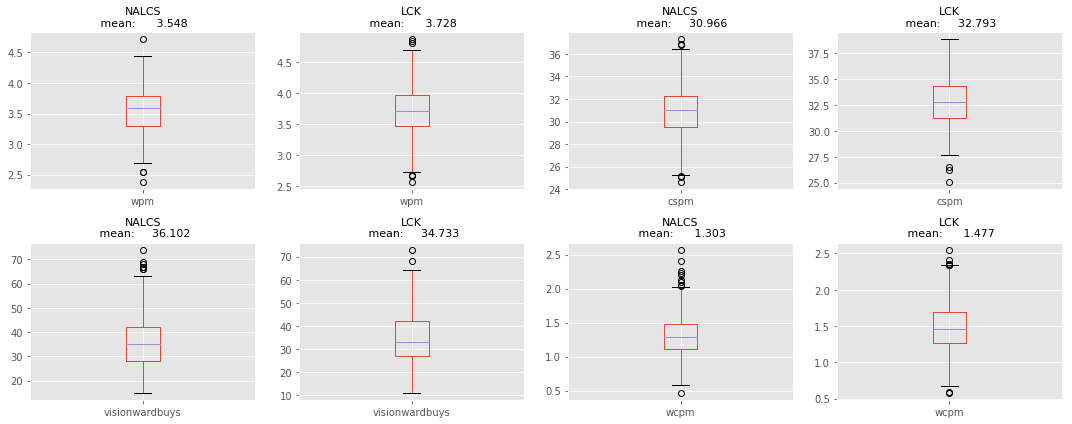

In [366]:
import analytics_utils
from analytics_utils import *
import importlib
importlib.reload(analytics_utils)

n=0
fig,axes = get_fig_axes(2,4,15,6,sharey=False)
for ii in overlap:
    if matches[ii].value_counts().index.shape[0] == 2:
        makeplot(matches,y,ii,"bar",[axes[n],axes[n+1]])
    else:
        makeplot(matches,y,ii,"notbar",[axes[n],axes[n+1]])
    n+=2
plt.tight_layout()
plt.show()

There is a difference in these features between NA and LCK teams but it's pretty small. LCK teams have slightly higher `cspm`, which is a measure of how much minions teams kill per minute (and thus a measure of gold generation), `wpm` and `wcpm`, which are measure of how many wards (which grant vision) teams put and clear respectively while NA teams have higher `visionwardbuys` which meanures how many vision wards teams buy. This seems to suggest that LCK teams are slightly better at constant gold generation and vision control. It's intersting that NA teams have higher vision ward buys but don't seem to invest in invisible wards which are less likely to be cleared by the enemy team. It's interesting that all these differences are actually pretty small but consitent. 

## Future Directions:

1. Examine features related to gold generation, vision control, objective control, team composition, and action separately
2. Look at NA vs LCK matches 
Current hypothesis:

NA is way more bloody that LCK. There are compositional differences (bans). LCK has better fundamentals (gold generation/cspm, vision control, objective control). 


In [158]:
#gold generation:
gold_gen = ["earnedgoldshare","totalgold","earnedgpm","goldspent","gspd","minionkills","monsterkills",
           "monsterkillsownjungle","monsterkillsenemyjungle","cspm","goldat10","oppgoldat10","gdat10",
           "goldat15","oppgoldat15","gdat15","csat10","oppcsat10","csdat10","csat15","oppcsat15","csdat15",
           "xpat10","oppxpat10","xpdat10"]
vision = ["wards","wpm","wardshare","wardkills","wcpm","visionwards","visionwardbuys","visiblewardclearrate",
         "invisiblewardclearrate"]
obj_ctr = ["teamdragkills","oppdragkills","elementals","oppelementals","firedrakes","waterdrakes","earthdrakes",
          "airdrakes","elders","oppelders","herald","heraldtime","ft","fttime","firstmidouter","teamtowerkills",
          "firsttothreetowers","opptowerkills","fbaron","fbarontime","teambaronkills","oppbaronkills"]
action = ["k","d","a","teamkills","teamdeaths","doubles","triples","quadras","pentas","fb","fbassist","fbvictim",
         "fbtime","kpm","okpm","ckpm","fd","fdtime","dmgtochamps","dmgtochampsperminute","dmgshare","gamelength"]
team_comp = ["champion","ban1","ban2","ban3","ban4","ban5","side"]
#print(na_players.loc[:,gold_gen].shape)
#print(na_players.loc[:,vision].shape)
#print(na_players.loc[:,obj_ctr].shape)
#print(na_players.loc[:,action].shape)
#print(na_players.loc[:,team_comp].shape)
#print(na_players.shape)
#print(na_players.columns.values)
na_players[action].shape

(3910, 22)

In [294]:
year = "2017"
focus = "player"
season = "playoffs"
joins = [year,focus,season]
anti_joins = ["na-cs","eu-cs"]
aliases = ["na","lck"]
leagues = ["NALCS","LCK"]
all_player_stats, all_teams = get_matches(db_dir, year, focus, season, aliases, leagues, joins, anti_joins)

NALCS    3910
Name: league, dtype: int64
LCK    3030
Name: league, dtype: int64


In [180]:
import analytics_utils
from analytics_utils import *
import importlib
importlib.reload(analytics_utils)
role = ""
var = obj_ctr[:]
var.append("league")
na_players = all_player_stats["NALCS"].loc[all_player_stats["NALCS"]["position"].str.contains(role),:]
lck_players = all_player_stats["LCK"].loc[all_player_stats["LCK"]["position"].str.contains(role),:]
print("#NA samples: {}\t#LCK samples: {}".format(na_players.shape[0],lck_players.shape[0]))
player_stats = {"NALCS":na_players.loc[:,var],"LCK":lck_players.loc[:,var]}
leagues = ["NALCS","LCK"]
variable = "league"
to_drop = ["patchno","gameid","url","index","team","gameid","playerid","Team","date","week","split","player"]
matches,data, y, colnames = get_final_table(leagues,variable,to_drop, player_stats)


#NA samples: 3910	#LCK samples: 3030


In [181]:
sup = supervised_analysis(data,y,colnames)
log_comp = sup.fit("Logit")
ada_comp = sup.fit("Adaboost")
tree_comp = sup.fit("Random Forest")
anova_comp = sup.anova()
#print(var)
#print(y.shape)
#print(data.shape)

Largest class/Naive accuracy:     0.5634

Logit Cross val mean: 0.6297037027467922 std: 0.021697429643261202
Logit test score: 0.6156340057636888
Logit AUC on test data: 0.594636541659281

Adaboost Cross val mean: 0.6986117616564764 std: 0.023539220128052336
Adaboost test score: 0.6891210374639769
Adaboost AUC on test data: 0.6734097642500823

Random Forest Cross val mean: 0.9373182617020378 std: 0.010490274751654576
Random Forest test score: 0.9499279538904899
Random Forest AUC on test data: 0.950363162914757


C:\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [11] are constant.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [182]:
import analytics_utils
from analytics_utils import *
import importlib
importlib.reload(analytics_utils)
num_feats = all_matches_players["LCK"].loc[:,all_matches_players["LCK"].dtypes != np.dtype('O')].shape[1]
print("Total # of features: {}".format(matches.shape[1]))
print("Total # of numerical features: {}".format(num_feats))
algs = ["LOGSITIC REGRESSION","ADABOOST","RANDOM FOREST", "ANOVA"]
srs = []
n=0
for ii in [anova_comp[:10],ada_comp[:10],tree_comp[:10],anova_comp[:10]]:
    ii = ii.rename_axis(algs[n],axis=0).rename("Importance")
    n+=1
    srs.append(ii)
display_side_by_side(srs[0],srs[1],srs[2],srs[3])

Total # of features: 22
Total # of numerical features: 67


,Importance
LOGSITIC REGRESSION,
fttime,0.650065
oppdragkills,0.076115
herald,0.072971
opptowerkills,0.058463
teambaronkills,0.030292
ft,0.023832
teamdragkills,0.018704
teamtowerkills,0.016093
firsttothreetowers,0.013998


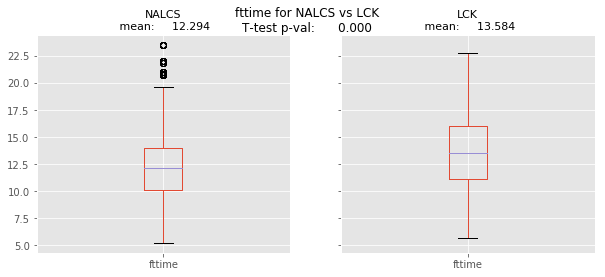

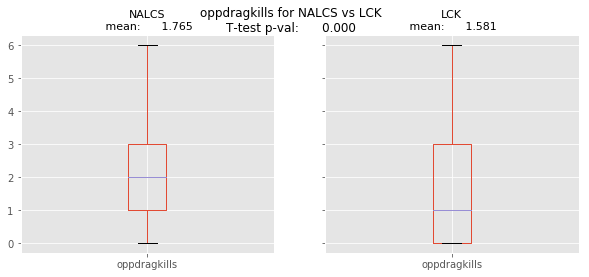

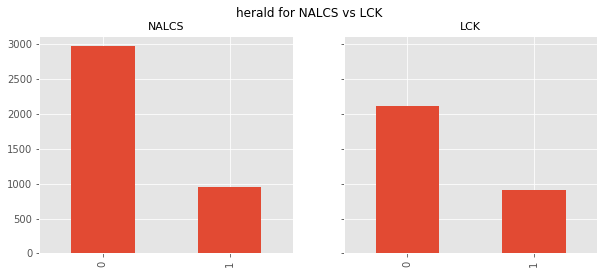

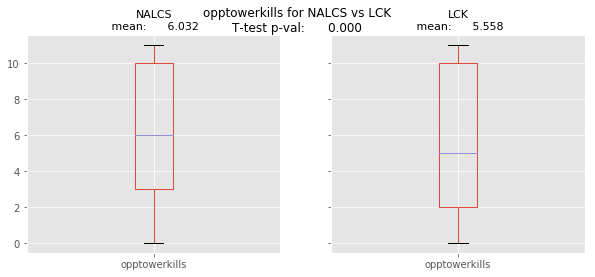

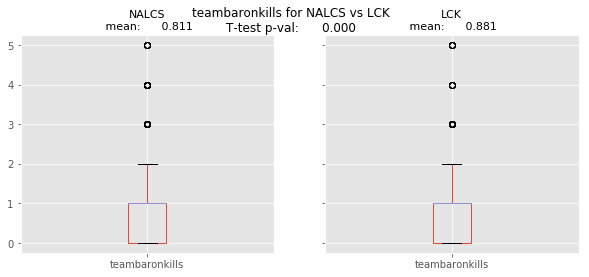

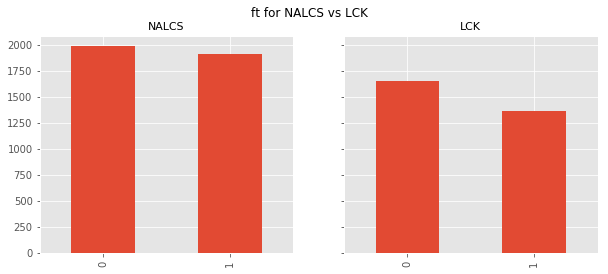

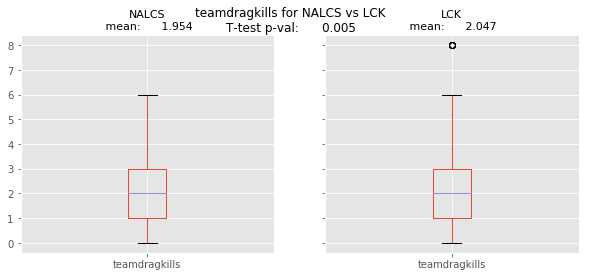

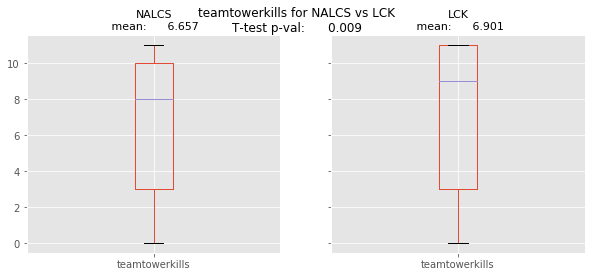

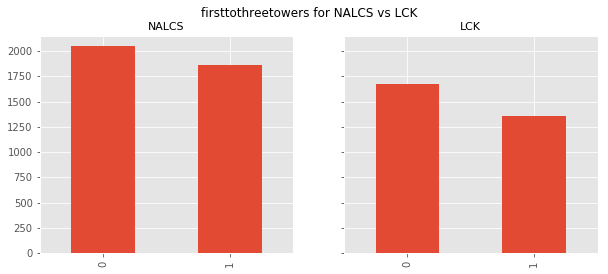

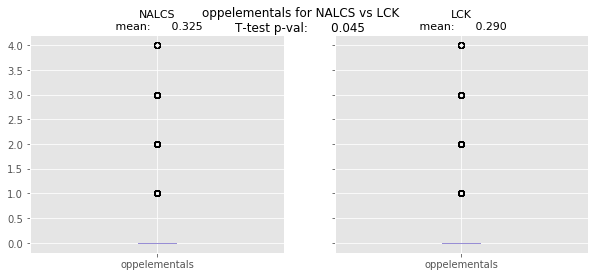

In [184]:
import analytics_utils
from analytics_utils import *
import importlib
importlib.reload(analytics_utils)

n=0
for ii in anova_comp.index.values[:10]:
    if matches[ii].value_counts().index.shape[0] == 2:
        makeplot(matches,y,ii,"bar")
    else:
        makeplot(matches,y,ii,"notbar")

In [30]:
na_players["position"].value_counts()

ADC        782
Top        782
Middle     782
Support    782
Jungle     782
Name: position, dtype: int64

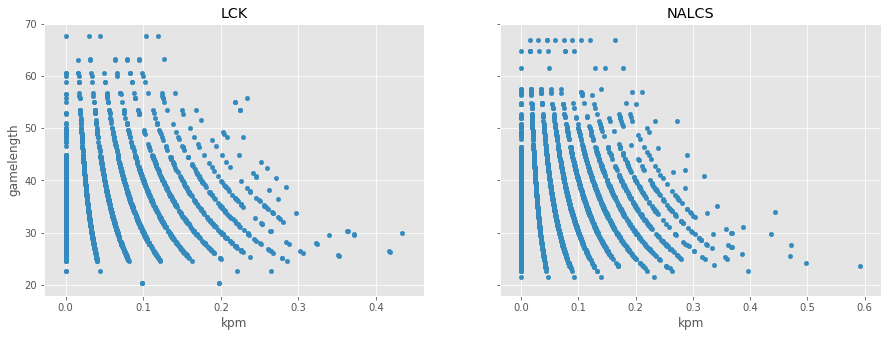

In [179]:
fig,axes = get_fig_axes(1,2,15,5,sharey=True)
feat = "kpm"
matches[y=="LCK"].plot.scatter(x=feat,y="gamelength",ax=axes[0])
axes[0].set_title("LCK")
matches[y=="NALCS"].plot.scatter(x=feat,y="gamelength",ax=axes[1])
axes[1].set_title("NALCS")
plt.show()

In [299]:
na_teams = all_teams["NALCS"]
lck_teams = all_teams["LCK"]
query = """SELECT * FROM '2017matchdata';"""
all_2017_matches = pd.read_sql_query(query,match)
print(all_2017_matches.shape)

(37404, 99)


In [332]:
na_matches = all_2017_matches.loc[all_2017_matches["team"].isin(na_teams.Team)]
na_matches = na_matches[(na_matches.league != "NALCS") & (na_matches.league != "LCK")]
lck_matches = all_2017_matches.loc[all_2017_matches["team"].isin(lck_teams.Team)]
lck_matches = lck_matches[(lck_matches.league != "NALCS") & (lck_matches.league != "LCK")]
select_matches = na_matches.append(lck_matches)
na_gameids = na_matches["gameid"].unique()
lck_gameids = lck_matches["gameid"].unique()
lck_vs_na = lck_matches[lck_matches["gameid"].isin(na_gameids)]
na_vs_lck = na_matches[na_matches["gameid"].isin(lck_gameids)]
print(na_vs_lck.shape)
print(lck_vs_na.shape)

(36, 99)
(36, 99)


In [342]:
na_vs_lck.league.value_counts()

WC     24
MSI    12
Name: league, dtype: int64

In [343]:
lck_vs_na.league.value_counts()

WC     24
MSI    12
Name: league, dtype: int64